# Experiments

TODO: Use 5-fold cross validation.

## Dataset
- `dev` only
- `dev` and part of `devtest` using `train_test_split`
- use same model for `normal` and `hard`, i.e. concat `dev` and `dev-hard`

## Text cleaning
- just `word_tokenize`
- remove punctuations
- remove stop words
- use Porter stemmer

## Feature engineering

- number of unique overlapping unigrams
- number of overlapping unigrams (probably not much difference)

Always use edit distance

### Misc
- Compute feature correlation
- Visualize feature distribution as well as a scatter plot of the 2D features.

In [1]:
import string
import editdistance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize

from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
punctuations = set(string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))
ps = nltk.PorterStemmer()

In [3]:
def load_file(path, skip_id=False, has_label=True):
    """
    has_label: also return label column if True
    return [['hello world', 'hi'], ['hi World', 'hello']]
    """
    first_lines = []
    second_lines = []
    if has_label:
        labels = []
    if skip_id:
        start_col_idx = 1
    else:
        start_col_idx = 0
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = chunks[start_col_idx]
            second = chunks[start_col_idx + 1]
            first_lines.append(first)
            second_lines.append(second)
            
            if has_label:
                label = int(chunks[start_col_idx + 2])
                labels.append(label)
    if has_label:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines, 
            'is_paraphrase': labels
        })
    else:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines
        })
    return ret

In [41]:
def clean_text(text, remove_punkt=False, remove_stopwords=False, stem=False):
    tokens = word_tokenize(text.lower())
    if remove_punkt:
        tokens = [tok for tok in tokens if not tok in punctuations]
    if remove_stopwords:
        tokens = [tok for tok in tokens if not tok in stopwords]
    if stem:
        tokens = [ps.stem(tok) for tok in tokens]
    return tokens

In [5]:
def construct_features(first_lines, second_lines):
    # number of unique overlapping unigrams, edit distance
    features = np.empty((len(first_lines), 2))
    for idx, tup in enumerate(zip(first_lines, second_lines)):
        first, second = tup
        num_unigrams = len(set(first).intersection(second))
        edit_dist = editdistance.eval(first, second)
        features[idx, 0] = num_unigrams
        features[idx, 1] = edit_dist
    return features

In [6]:
def model_pipeline(X, y, X_val, y_val):
    """
    X, y: train; X_val, y_val: validation
    """
    model = MLPClassifier(max_iter=1000, random_state=0)
    model.fit(X, y)
    y_pred = model.predict(X)
    train_accu = accuracy_score(y, y_pred)
    print('Train accuray: {:4f}'.format(train_accu))
    y_val_pred = model.predict(X_val)
    val_accu = accuracy_score(y_val, y_val_pred)
    print('Validation accuracy: {:4f}'.format(val_accu))
    # construct confusion matrix on validation set
    conf_mat = confusion_matrix(y_val, y_val_pred)
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True labels')
    
    ret = {
        'model': model,
        'train_accu': train_accu,
        'val_accu': val_accu,
        'conf_mat': ax
    }
    return ret

In [39]:
def run_experiment(train_df, val_df, call_clean_text=True, clean_text_kws=None):
    if call_clean_text:
        X = construct_features(train_df.line1.apply(clean_text, **clean_text_kws), 
                               train_df.line2.apply(clean_text, **clean_text_kws))
        X_val = construct_features(val_df.line1.apply(clean_text, **clean_text_kws),
                                   val_df.line2.apply(clean_text, **clean_text_kws))
    else:
        X = construct_features(train_df.line1, train_df.line2)
        X_val = construct_features(val_df.line1, val_df.line2)
        
    y = train_df.is_paraphrase
    y_val = val_df.is_paraphrase
    ret = model_pipeline(X, y, X_val, y_val)
    return ret

# Load data

In [8]:
dev = load_file('data/dev+devtest/dev.tsv')
devtest = load_file('data/dev+devtest/devtest.tsv')
test = load_file('data/test_no_labels.tsv', skip_id=True, has_label=False)
dev_hard = load_file('data/heldout-hard/dev.hard.tsv')
devtest_hard = load_file('data/heldout-hard/devtest.hard.tsv')
test_hard = load_file('data/heldout-hard/test.hard.tsv', has_label=False)

In [9]:
dev.head()

,line1,line2,is_paraphrase
0,I don't know what you're sayin'.,I don't know what you're talking about.,1
1,They're on the next flight home.,he's going home next flight.,1
2,Such stories.,the stories.,1
3,On your left!,in the left!,1
4,I don't think it's actually a good idea...,I don't think it's a good idea.,1


In [12]:
experiments = {}

# Baseline
- Use dev only, train different models for normal and hard
- Test on devtest
- No text cleaning, which means the string are parsed character by character

Train accuray: 0.841076
Validation accuracy: 0.813665


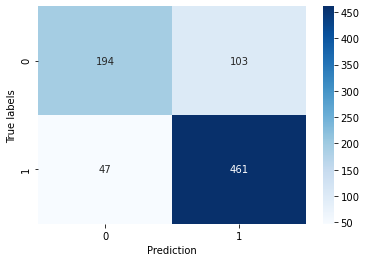

In [13]:
# normal
ret = run_experiment(dev, devtest, call_clean_text=False)
experiments['baseline'] = ret

Train accuray: 0.725000
Validation accuracy: 0.700000


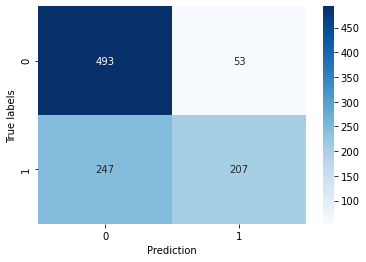

In [14]:
# hard
ret = run_experiment(dev_hard, devtest_hard, call_clean_text=False)
experiments['baseline_hard'] = ret

# With tokenization

Train accuray: 0.844743
Validation accuracy: 0.829814


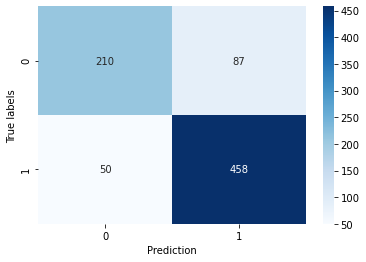

In [15]:
# normal
ret = run_experiment(dev, devtest, call_clean_text=True)
experiments['tokenized'] = ret

Train accuray: 0.689000
Validation accuracy: 0.668000


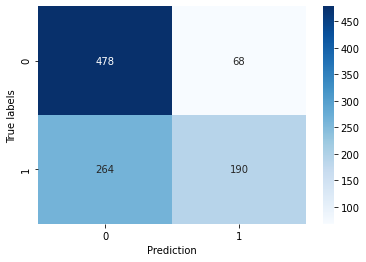

In [16]:
# hard
ret = run_experiment(dev_hard, devtest_hard, call_clean_text=True)
experiments['tokenized_hard'] = ret

Concat and `train_test_split` dev and devtest for more training data. From the result it looks like bigger datasets are better.

In [18]:
normal = pd.concat([dev, devtest])
hard = pd.concat([dev_hard, devtest_hard])
dev_big, devtest_small = train_test_split(normal, random_state=0)
dev_hard_big, devtest_hard_small = train_test_split(hard, random_state=0)

In [19]:
print(len(dev_hard), len(dev_hard_big))
dev_hard_big.head()

1000 1500


,line1,line2,is_paraphrase
45,A proposed Mahadayi River ( Mandovi River ) wa...,A proposed Mahadayi River ( Mandovi River ) wa...,1
937,Rıza Maksut İşman ( 1915 in Istanbul -- Decemb...,Rıza Maksut İşman ( 1915 in İzmir -- December ...,0
658,A Peri whose power is in her hair appears in E...,A Peri whose force appears in her hair is in E...,0
529,This made him the first 994nd grader to play f...,This made him the 994th first grader to play f...,0
895,The first or `` narrow '' system consists of r...,The first or `` red '' system consists of narr...,0


Train accuray: 0.842235
Validation accuracy: 0.837438


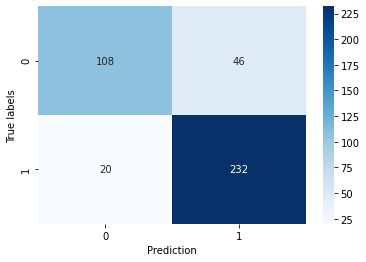

In [21]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True)
experiments['big'] = ret

Train accuray: 0.681333
Validation accuracy: 0.686000


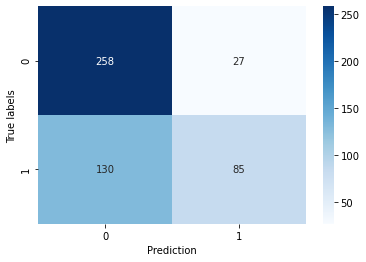

In [23]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True)
experiments['big_hard'] = ret

Train a single model for both normal and hard by concatenating all data. The results were actually worse, which might mean that the normal and hard version are very different.

Train accuray: 0.690099
Validation accuracy: 0.667770


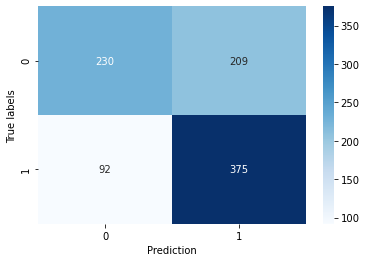

In [24]:
ret = run_experiment(
    pd.concat([dev_big, dev_hard_big]), 
    pd.concat([devtest_small, devtest_hard_small]), 
    call_clean_text=True)
experiments['combined'] = ret

Train accuray: 0.690099
Validation accuracy: 0.812808


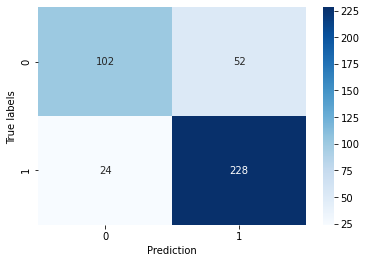

In [30]:
# evaluate performance separately
# the model has never seen devtest_small or devtest_hard_small
# okay to call run_experiment here since I set training to be deterministic
ret = run_experiment(
    pd.concat([dev_big, dev_hard_big]), 
    devtest_small,
    call_clean_text=True)
experiments['combined_normal'] = ret

Train accuray: 0.690099
Validation accuracy: 0.550000


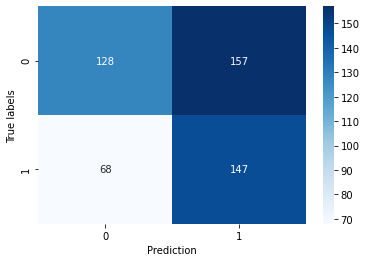

In [31]:
ret = run_experiment(
    pd.concat([dev_big, dev_hard_big]), 
    devtest_hard_small,
    call_clean_text=True)
experiments['combined_hard'] = ret

# Text cleaning
- Remove punctuations
- Remove stopwords
- Stem

Use the bigger sets.

Train accuray: 0.823336
Validation accuracy: 0.852217


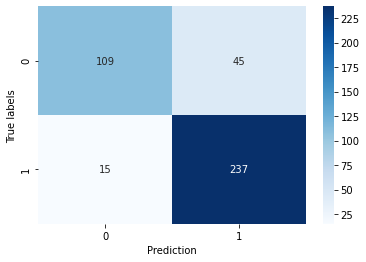

In [42]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True})
experiments['no_punkt'] = ret

Train accuray: 0.681333
Validation accuracy: 0.686000


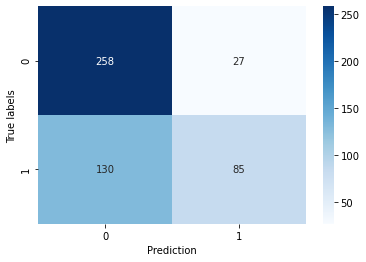

In [33]:
# hard
ret = run_experiment(dev_hard_big, devtest_hard_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True})
experiments['no_punkt_hard'] = ret

Train accuray: 0.842235
Validation accuracy: 0.837438


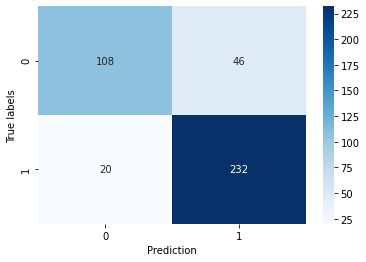

In [35]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'remove_stopwords': True})
experiments['no_punkt_stopwords'] = ret

Train accuray: 0.842235
Validation accuracy: 0.837438


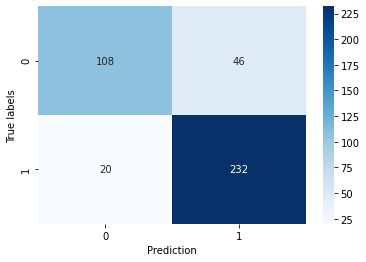

In [36]:
# normal
ret = run_experiment(dev_big, devtest_small, call_clean_text=True, 
                    clean_text_kws={'remove_punkt': True, 
                                    'remove_stopwords': True,
                                    'stem': True
                                   })
experiments['stem'] = ret

# Feature visualization

# Submission

In [12]:
submission = pd.DataFrame({
    'id': range(len(y_pred)),
    'Category': y_pred
})

In [13]:
# submission.to_csv('output/submission.csv', index=False)

In [17]:
# dump(model, 'output/mlp-hard.joblib') 